# ABP Módulo 6 – Aplicación Ciencia de Datos

### 1) Cargar dataset simulado

In [2]:
import pandas as pd
df = pd.read_csv('abp_mod6_dataset.csv')
df.head()

,age,income,debt_ratio,delinquencies,credit_history_years,has_mortgage,has_dependents,employment_years,approved,credit_limit
0,22,1083131,0.000000,0,7.351319,1,1,6.231550,1,1234094
1,59,1158604,0.043281,0,8.350566,1,0,1.369610,1,1756771
2,52,1099209,0.200053,0,10.855870,0,0,12.134704,1,1663618
3,41,1261025,0.249609,0,3.141906,0,0,9.154001,1,1405778
4,40,1788596,0.276490,1,11.698463,0,1,9.634364,1,1971274


### 2) Preparar datos y pipelines

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, mean_absolute_error, mean_squared_error, r2_score
import numpy as np, math

X = df.drop(columns=['approved','credit_limit'])
y_cls = df['approved']
y_reg = df['credit_limit']

num_cols = ["age","income","debt_ratio","delinquencies","credit_history_years","employment_years"]
cat_cols = ["has_mortgage","has_dependents"]
preprocess = ColumnTransformer([('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), cat_cols)])

### 3) Clasificación – Entrenamiento y métricas

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cls, test_size=0.2, random_state=7, stratify=y_cls)
logit = Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))])
rf    = Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=300, random_state=7))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
import numpy as np
from sklearn.model_selection import cross_val_score
auc_logit = cross_val_score(logit, X_train, y_train, cv=cv, scoring='roc_auc').mean()
auc_rf    = cross_val_score(rf,    X_train, y_train, cv=cv, scoring='roc_auc').mean()
best = rf if auc_rf > auc_logit else logit
best.fit(X_train, y_train)
y_prob = best.predict_proba(X_test)[:,1]
y_hat  = (y_prob >= 0.5).astype(int)
acc  = accuracy_score(y_test, y_hat)
prec = precision_score(y_test, y_hat)
rec  = recall_score(y_test, y_hat)
f1   = f1_score(y_test, y_hat)
auc  = roc_auc_score(y_test, y_prob)
(acc, prec, rec, f1, auc)

(0.7583333333333333,
 0.9404761904761905,
 0.7669902912621359,
 0.8449197860962567,
 0.8349514563106797)

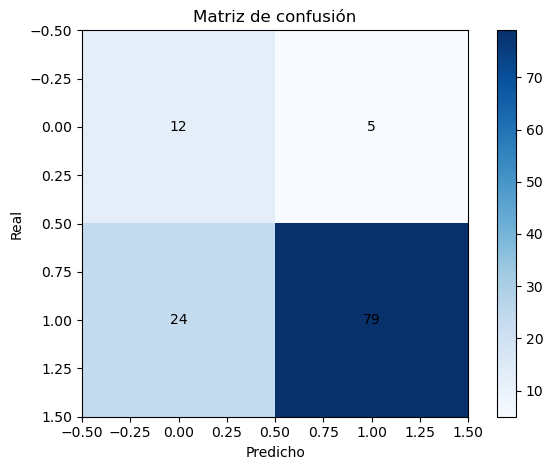

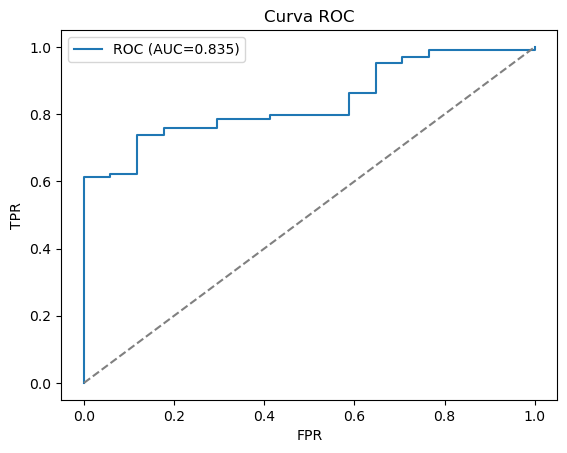

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc as sk_auc

# Matriz de confusión
cm = confusion_matrix(y_test, y_hat)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')  # 'im' es el mappable
ax.set_title('Matriz de confusión')
ax.set_xlabel('Predicho')
ax.set_ylabel('Real')

# Anotar cada celda con su conteo
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center', color='black')

# Agregar la barra de color UNA sola vez usando el mappable
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

# Curva ROC
# Asegúrate de que y_prob sea la probabilidad del positivo (por ejemplo, predict_proba(... )[:, 1])
fpr, tpr, thr = roc_curve(y_test, y_prob)
roc_auc = sk_auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
ax.plot([0, 1], [0, 1], '--', color='gray')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Curva ROC')
ax.legend()
plt.show()


### 4) Regresión – Entrenamiento y métricas

In [15]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=7)
linreg = Pipeline([('prep', preprocess), ('reg', LinearRegression())]).fit(X_train_r, y_train_r)
rfr    = Pipeline([('prep', preprocess), ('reg', RandomForestRegressor(n_estimators=300, random_state=7))]).fit(X_train_r, y_train_r)

def eval_reg(model, Xtr, Xte, ytr, yte):
    import math
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    pred = model.predict(Xte)
    mae = mean_absolute_error(yte, pred)
    rmse = math.sqrt(mean_squared_error(yte, pred))
    r2 = r2_score(yte, pred)
    return mae, rmse, r2

metrics_lin = eval_reg(linreg, X_train_r, X_test_r, y_train_r, y_test_r)
metrics_rfr = eval_reg(rfr,    X_train_r, X_test_r, y_train_r, y_test_r)
metrics_lin, metrics_rfr

((106542.17073796465, 134130.48904596764, 0.9125304198905458),
 (167344.04227777774, 209402.15603858643, 0.7868112302053928))

### 5) Persistencia del mejor modelo y API Flask

In [16]:
import joblib
joblib.dump(best, 'model_pipeline.joblib')
print('Modelo guardado en model_pipeline.joblib')

Modelo guardado en model_pipeline.joblib


**Ejecutar API**
```bash
pip install flask joblib scikit-learn
python app.py
```

**Ejemplo de request**
```bash
curl -X POST http://127.0.0.1:8000/predict \
 -H 'Content-Type: application/json' \
 -d '{"age":35,"income":1500000,"debt_ratio":0.3,"delinquencies":0,"credit_history_years":10,"has_mortgage":0,"has_dependents":0,"employment_years":8}'
```

**Respuesta Esperada**
```json
{
  "probability": 0.87,
  "prediction": 1
}
```